In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.impute import KNNImputer
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
import warnings

# Cleaning

In [10]:
flu = pd.read_csv("data.csv")

flu["georegion"] = flu["georegion"].astype(str)
flu["sex"] = flu["sex"].astype(str)
flu = flu.loc[flu["georegion"] == "CH" & flu["sex"] == "all"]
flu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9639 entries, 0 to 9638
Data columns (total 16 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   valueCategory                    9639 non-null   object 
 1   temporal                         9639 non-null   object 
 2   temporal_type                    9639 non-null   object 
 3   georegion                        9639 non-null   object 
 4   georegion_type                   9639 non-null   object 
 5   agegroup                         9639 non-null   object 
 6   agegroup_type                    9639 non-null   object 
 7   sex                              9639 non-null   object 
 8   value                            7910 non-null   float64
 9   popExtrapolation                 7938 non-null   float64
 10  totalConsultationsExtrapolation  7938 non-null   float64
 11  incValue                         7910 non-null   float64
 12  prctConsultations   

In [ ]:
flu = pd.read_csv("data.csv")

flu["georegion"] = flu["georegion"].astype(str)
flu["sex"] = flu["sex"].astype(str)
#keep only the whole ch
flu = flu.loc[(flu["georegion"] == "CH") 
            & (flu["sex"] == "all") 
            & (flu["agegroup"] == "all")]
# Select only the desired columns
flu_clean = flu[["value", "temporal"]]

# Remove 'W' from the "temporal" column and replace any non-numeric characters
flu_clean["temporal"] = flu_clean["temporal"].str.replace('W', '')
#CHANGE into datetime
flu_clean["temporal"] = flu_clean["temporal"] + "-1"
flu_clean["temporal"] = pd.to_datetime(flu_clean["temporal"],format='%Y-%W-%w')
flu_clean["temporal"]
#sort by time
flu_clean = flu_clean.sort_values(by='temporal')

flu_clean_imputed = flu_clean.copy()
imputer = KNNImputer(n_neighbors=10)
# Reshape the target column to a 2D array (required by the imputer)
impute_data = flu_clean_imputed['value'].values.reshape(-1, 1)
flu_clean_imputed['value'] = imputer.fit_transform(impute_data)
flu_clean_imputed['value'].isnull().any()
#No missing value

flu_clean_imputed.reset_index()
flu_clean_imputed['temporal'] = pd.to_datetime(flu_clean['temporal'])
flu_clean_imputed = flu_clean_imputed.set_index('temporal')
flu_clean_imputed.index = flu_clean_imputed.index.strftime('%Y-%m-%d')
flu_clean_imputed

Graph it

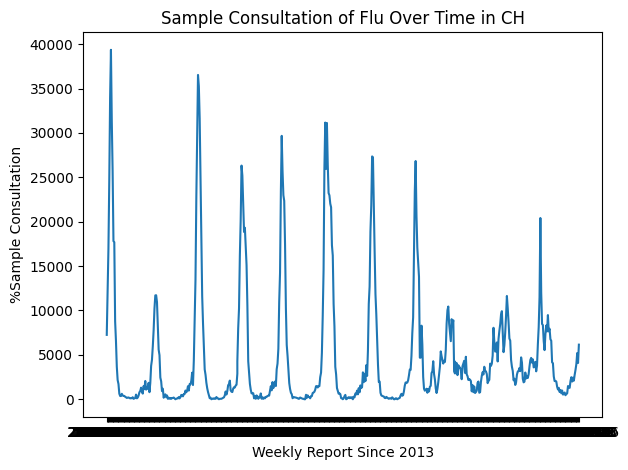

In [19]:
plt.plot(flu_clean_imputed['value'])
plt.title('Weekly Flu Cases Over Time in CH')
plt.xlabel('Weekly Report Since 2013')
plt.ylabel('%Sample Consultation')
plt.tight_layout()
plt.show()

# Decomposition

In [20]:
train = flu_clean_imputed[:520]
test = flu_clean_imputed[520:]
print(train)
print(test)

              value
temporal           
2013-01-07   7253.2
2013-01-14  12313.6
2013-01-21  16915.8
2013-01-28  24627.3
2013-02-04  34004.9
...             ...
2022-11-14   3146.8
2022-11-21   3792.6
2022-11-28   6193.2
2022-12-05   8131.4
2022-12-12  11500.2

[520 rows x 1 columns]
              value
temporal           
2022-12-19  20421.7
2022-12-26  12002.7
2023-01-02   8486.2
2023-01-09   8355.2
2023-01-16   6544.5
2023-01-23   5536.0
2023-01-30   7303.0
2023-02-06   8305.3
2023-02-13   7645.6
2023-02-20   9482.5
2023-02-27   7642.9
2023-03-06   7944.4
2023-03-13   6768.2
2023-03-20   6586.4
2023-03-27   4160.5
2023-04-03   4062.7
2023-04-10   2578.8
2023-04-17   2045.8
2023-04-24   2067.6
2023-05-01   2005.6
2023-05-08   1417.4
2023-05-15   1099.3
2023-05-22   1287.2
2023-05-29    812.7
2023-06-05   1053.0
2023-06-12    672.9
2023-06-19    986.6
2023-06-26    525.2
2023-07-03    573.3
2023-07-10    759.4
2023-07-17    453.5
2023-07-24    589.0
2023-07-31    649.3
2023-08-07   148

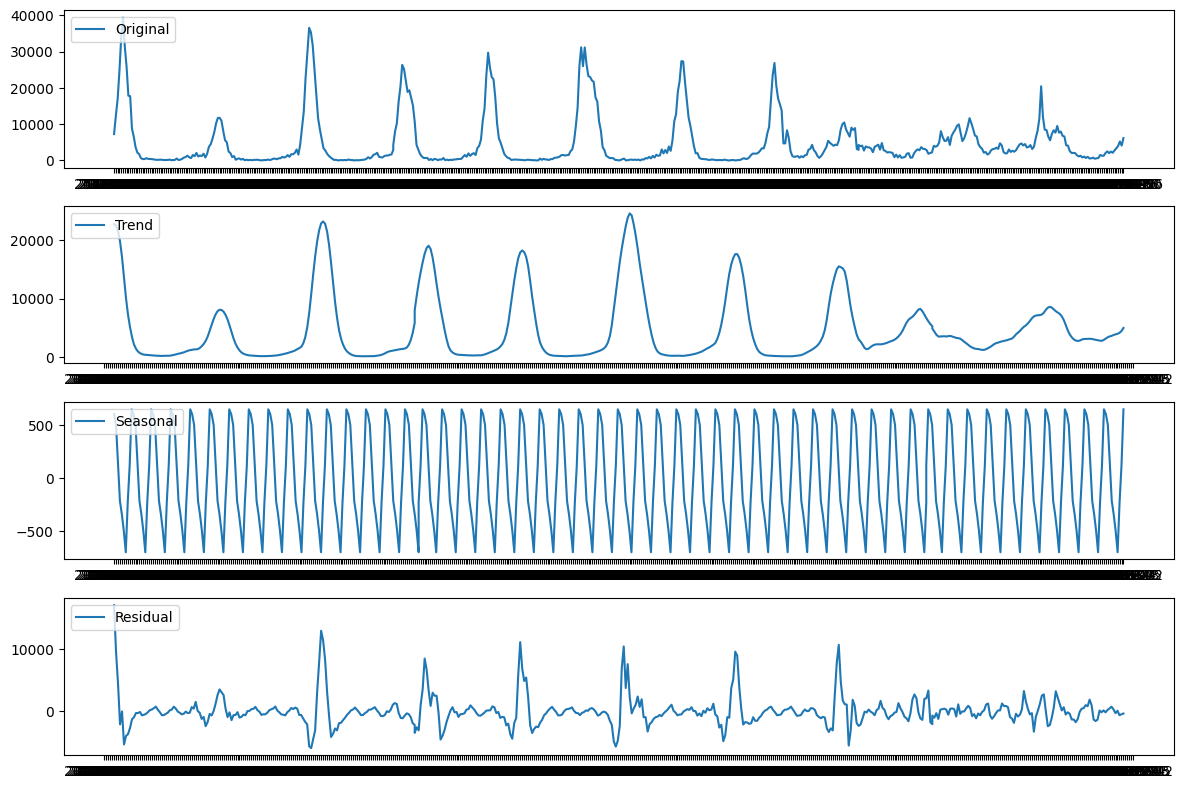

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform seasonal decomposition
decomp = seasonal_decompose(train['value'], model='additive', period= 10)
trend = decomp.trend
seasonal = decomp.seasonal
residual = decomp.resid

# Plot the components
plt.figure(figsize=(12, 8))

# Original Time Series
plt.subplot(4, 1, 1)
plt.plot(flu_clean_imputed['value'], label='Original')
plt.legend(loc='upper left')

# Trend Component
plt.subplot(4, 1, 2)
plt.plot(trend, label='Trend')
plt.legend(loc='upper left')

# Seasonal Component
plt.subplot(4, 1, 3)
plt.plot(seasonal, label='Seasonal')
plt.legend(loc='upper left')

# Residual Component
plt.subplot(4, 1, 4)
plt.plot(residual, label='Residual')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

# KPSS and ADF

In [22]:
# Perform the KPSS test
result = kpss(train['value'])

# Print the test statistic and p-value
print(f'KPSS Test Statistic: {result[0]}')
print(f'P-value: {result[1]}')

# Compare the test statistic with critical values to make a decision
if result[1] < 0.05:
    print('The time series is non-stationary (reject the null hypothesis), need for differencing')
else:
    print('The time series is stationary (do not reject the null hypothesis), no need for differencing')

KPSS Test Statistic: 0.023747434017804294
P-value: 0.1
The time series is stationary (do not reject the null hypothesis), no need for differencing


/var/folders/__/36t3n6rx1l1fd_9216pzns100000gn/T/ipykernel_50552/2891729970.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(train['value'])


In [23]:
# Perform the ADF test
result = adfuller(train['value'])

# Extract and print the test statistic and p-value
adf_statistic = result[0]
p_value = result[1]
print(f'ADF Test Statistic: {adf_statistic}')
print(f'P-value: {p_value}')

# Compare the test statistic with critical values to make a decision
if p_value < 0.05:
    print('The time series is stationary (reject the null hypothesis)')
else:
    print('The time series is non-stationary (do not reject the null hypothesis)')


ADF Test Statistic: -6.4455456184396045
P-value: 1.569223910640167e-08
The time series is stationary (reject the null hypothesis)


# ACF and PACF

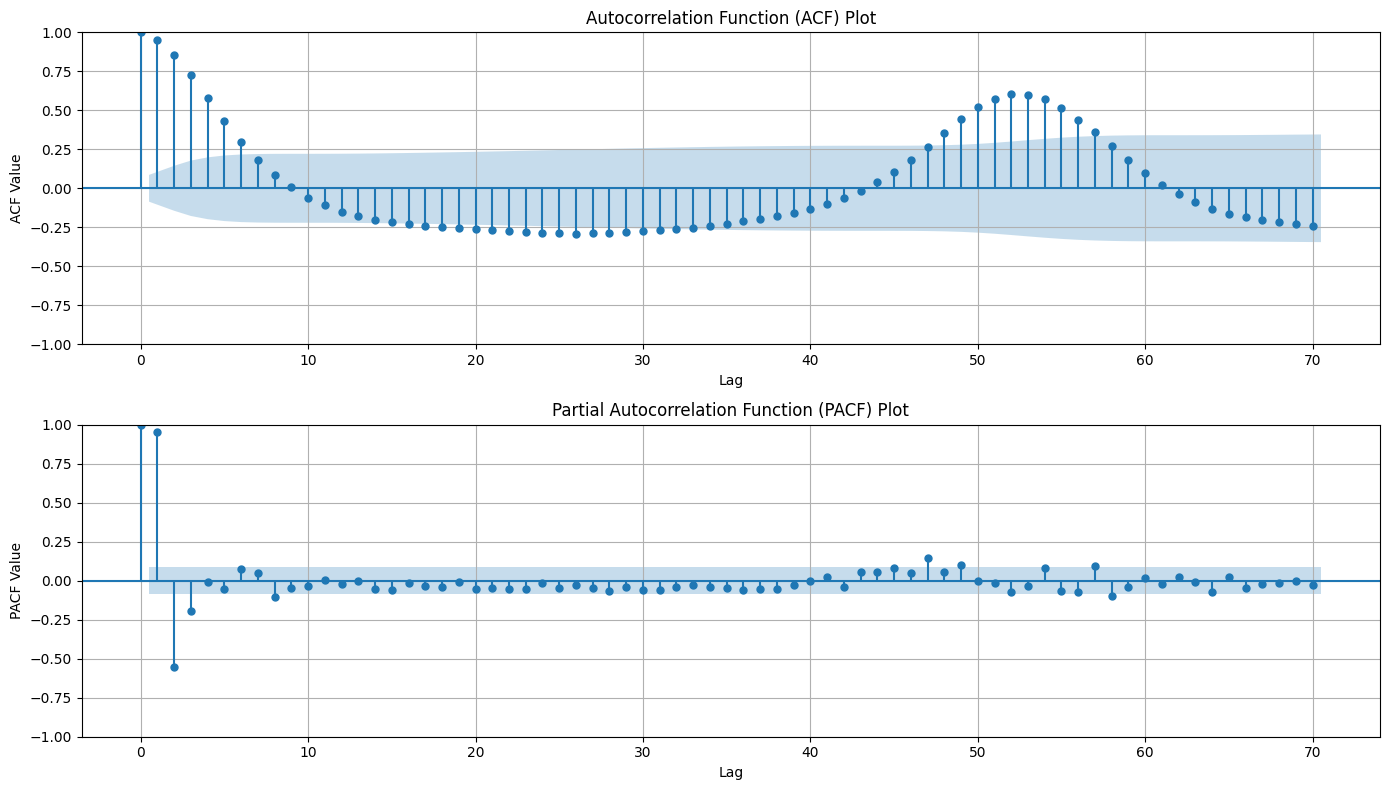

In [24]:
fig, axs = plt.subplots(2, 1, figsize=(14, 8))

# Plot the ACF
plot_acf(train['value'], lags=70, ax=axs[0])  # You can specify the number of lags to display
axs[0].set_title('Autocorrelation Function (ACF) Plot')
axs[0].set_xlabel('Lag')
axs[0].set_ylabel('ACF Value')
axs[0].grid()

# Plot the PACF
plot_pacf(train['value'], lags=70, ax=axs[1])  # You can specify the number of lags to display
axs[1].set_title('Partial Autocorrelation Function (PACF) Plot')
axs[1].set_xlabel('Lag')
axs[1].set_ylabel('PACF Value')
axs[1].grid()

plt.tight_layout()
plt.show() 
# PACF shows the direct effect of each lag on yt, we can see that lag 1, 2, and 3 have the most impact on yt, and a drastic decaying after lag 3
# the decaying PACF also shows the y is not stationary 
# ACF shows that an order of lag 6 has an effect on yt
# Curving ACF suggests transformation??

# Log-transformation

In [25]:
flu_clean_imputed['value_log'] = flu_clean_imputed['value'] + 1
y_log = np.log(flu_clean_imputed['value_log'])
if (flu_clean_imputed['value_log'] == 0).any():
    print("There are zeros in the column")
else:
    print("No zeros in the column")
flu_clean_imputed["log"] = y_log
flu_clean_imputed = flu_clean_imputed.rename(columns={'value': 'original'})
flu_clean_imputed = flu_clean_imputed.drop('value_log', axis = 1)
train = flu_clean_imputed[:520]
test = flu_clean_imputed[520:]
print(train)
print(test)

No zeros in the column
            original        log
temporal                       
2013-01-07    7253.2   8.889336
2013-01-14   12313.6   9.418541
2013-01-21   16915.8   9.736062
2013-01-28   24627.3  10.111651
2013-02-04   34004.9  10.434289
...              ...        ...
2022-11-14    3146.8   8.054459
2022-11-21    3792.6   8.241071
2022-11-28    6193.2   8.731369
2022-12-05    8131.4   9.003611
2022-12-12   11500.2   9.350207

[520 rows x 2 columns]
            original       log
temporal                      
2022-12-19   20421.7  9.924402
2022-12-26   12002.7  9.392970
2023-01-02    8486.2  9.046314
2023-01-09    8355.2  9.030759
2023-01-16    6544.5  8.786533
2023-01-23    5536.0  8.619208
2023-01-30    7303.0  8.896177
2023-02-06    8305.3  9.024770
2023-02-13    7645.6  8.942016
2023-02-20    9482.5  9.157309
2023-02-27    7642.9  8.941663
2023-03-06    7944.4  8.980348
2023-03-13    6768.2  8.820138
2023-03-20    6586.4  8.792914
2023-03-27    4160.5  8.333631
2023-04-03

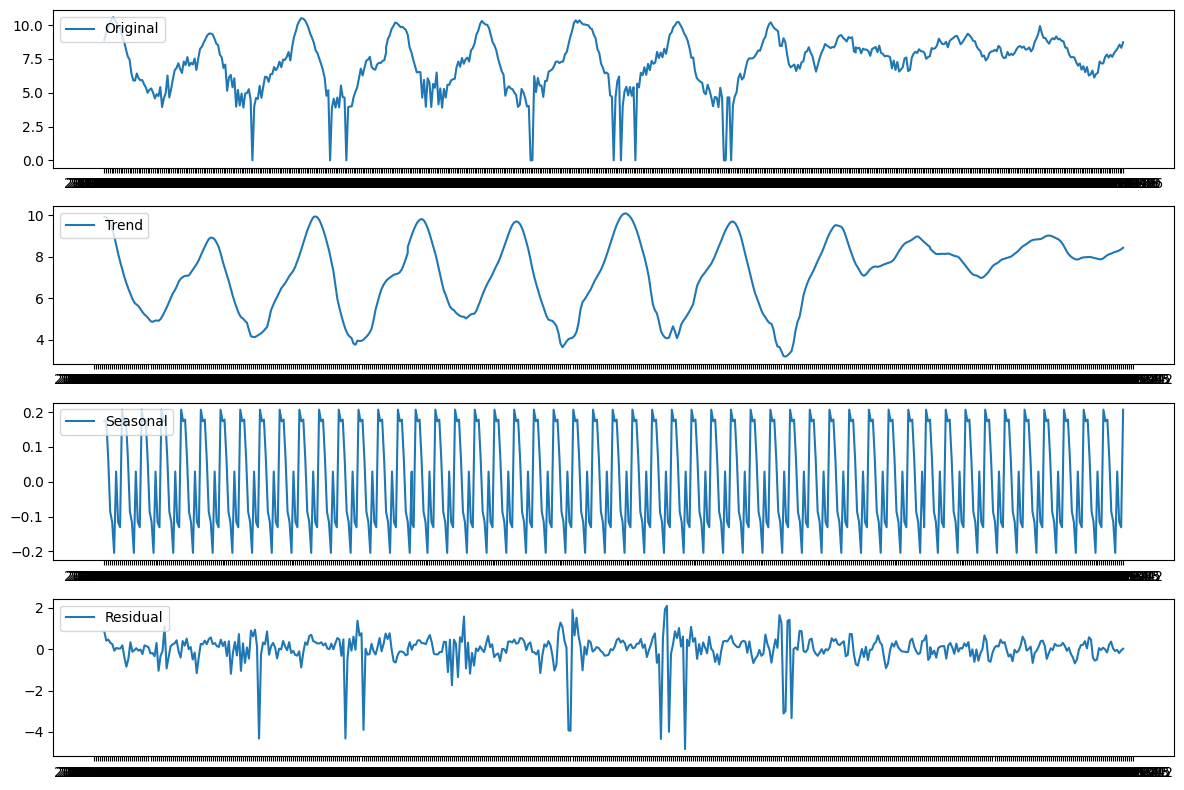

In [26]:
decomp = seasonal_decompose(train['log'], model='additive', period= 10)
trend = decomp.trend
seasonal = decomp.seasonal
residual = decomp.resid

# Plot the components
plt.figure(figsize=(12, 8))

# Original Time Series
plt.subplot(4, 1, 1)
plt.plot(flu_clean_imputed['log'], label='Original')
plt.legend(loc='upper left')

# Trend Component
plt.subplot(4, 1, 2)
plt.plot(trend, label='Trend')
plt.legend(loc='upper left')

# Seasonal Component
plt.subplot(4, 1, 3)
plt.plot(seasonal, label='Seasonal')
plt.legend(loc='upper left')

# Residual Component
plt.subplot(4, 1, 4)
plt.plot(residual, label='Residual')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()
# The pattern persists after seasonal differencing, which might implies a need for log transformation

## KPSS and ADF with Log_transformation

In [27]:
# Perform the KPSS test
result = kpss(train['log'])

# Print the test statistic and p-value
print(f'KPSS Test Statistic: {result[0]}')
print(f'P-value: {result[1]}')

# Compare the test statistic with critical values to make a decision
if result[1] < 0.05:
    print('The time series is non-stationary (reject the null hypothesis), need for differencing')
else:
    print('The time series is stationary (do not reject the null hypothesis), no need for differencing')

KPSS Test Statistic: 0.3162779692145456
P-value: 0.1
The time series is stationary (do not reject the null hypothesis), no need for differencing


/var/folders/__/36t3n6rx1l1fd_9216pzns100000gn/T/ipykernel_50552/1446348268.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(train['log'])


In [28]:
# Perform the ADF test
result = adfuller(train['log'])

# Extract and print the test statistic and p-value
adf_statistic = result[0]
p_value = result[1]
print(f'ADF Test Statistic: {adf_statistic}')
print(f'P-value: {p_value}')

# Compare the test statistic with critical values to make a decision
if p_value < 0.05:
    print('The time series is stationary (reject the null hypothesis)')
else:
    print('The time series is non-stationary (do not reject the null hypothesis)')

ADF Test Statistic: -6.294730154355576
P-value: 3.5286032150786747e-08
The time series is stationary (reject the null hypothesis)


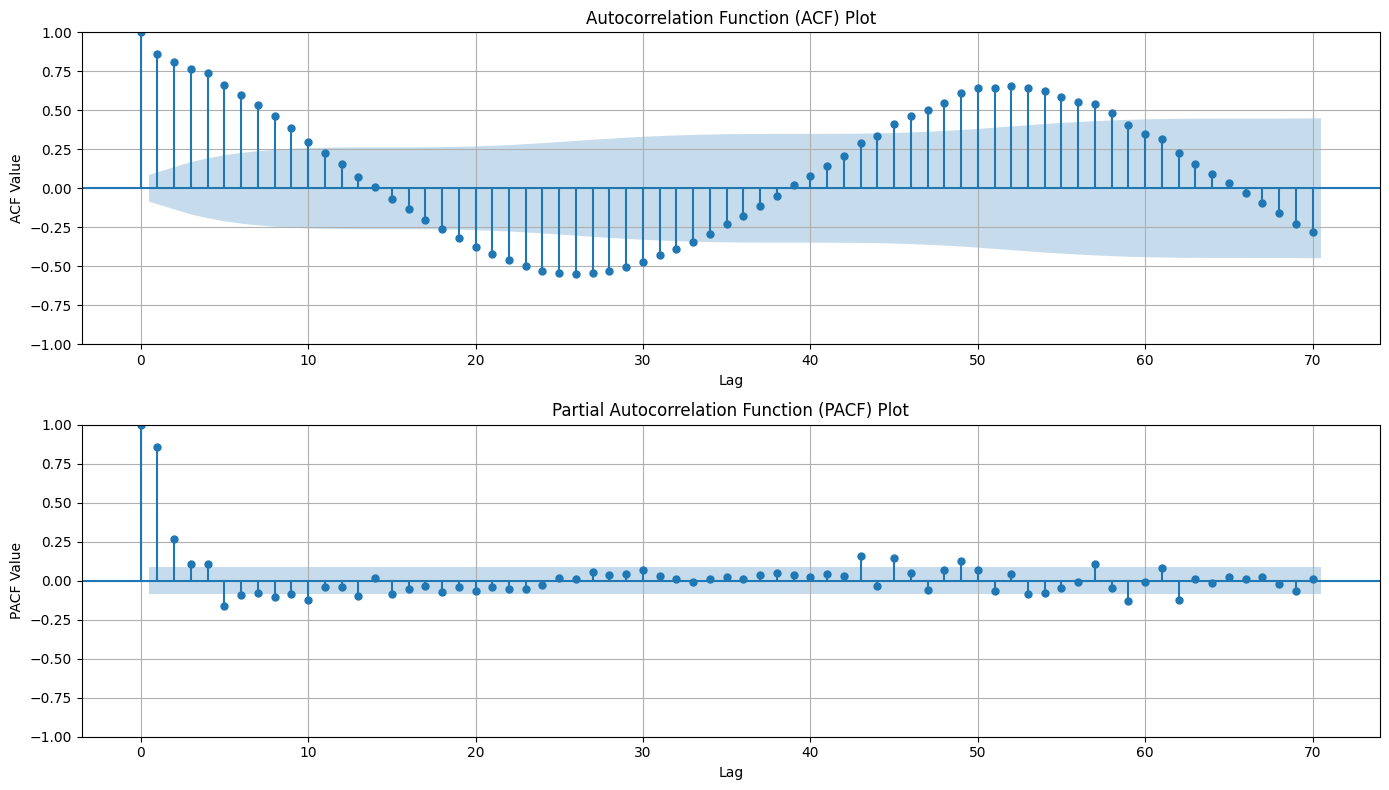

In [29]:
fig, axs = plt.subplots(2, 1, figsize=(14, 8))

# Plot the ACF
plot_acf(train["log"], lags=70, ax=axs[0])  # You can specify the number of lags to display
axs[0].set_title('Autocorrelation Function (ACF) Plot')
axs[0].set_xlabel('Lag')
axs[0].set_ylabel('ACF Value')
axs[0].grid()

# Plot the PACF
plot_pacf(train["log"], lags=70, ax=axs[1])  # You can specify the number of lags to display
axs[1].set_title('Partial Autocorrelation Function (PACF) Plot')
axs[1].set_xlabel('Lag')
axs[1].set_ylabel('PACF Value')
axs[1].grid()

plt.tight_layout()
plt.show() 
# Seems to have a pattern on ACF with no decay, which could be an indication on non-stationality.
# From ACF and PACF we could induce that the optimum mivong average is 9 and the autoregressive order is 4.

## 1st Order Differencing

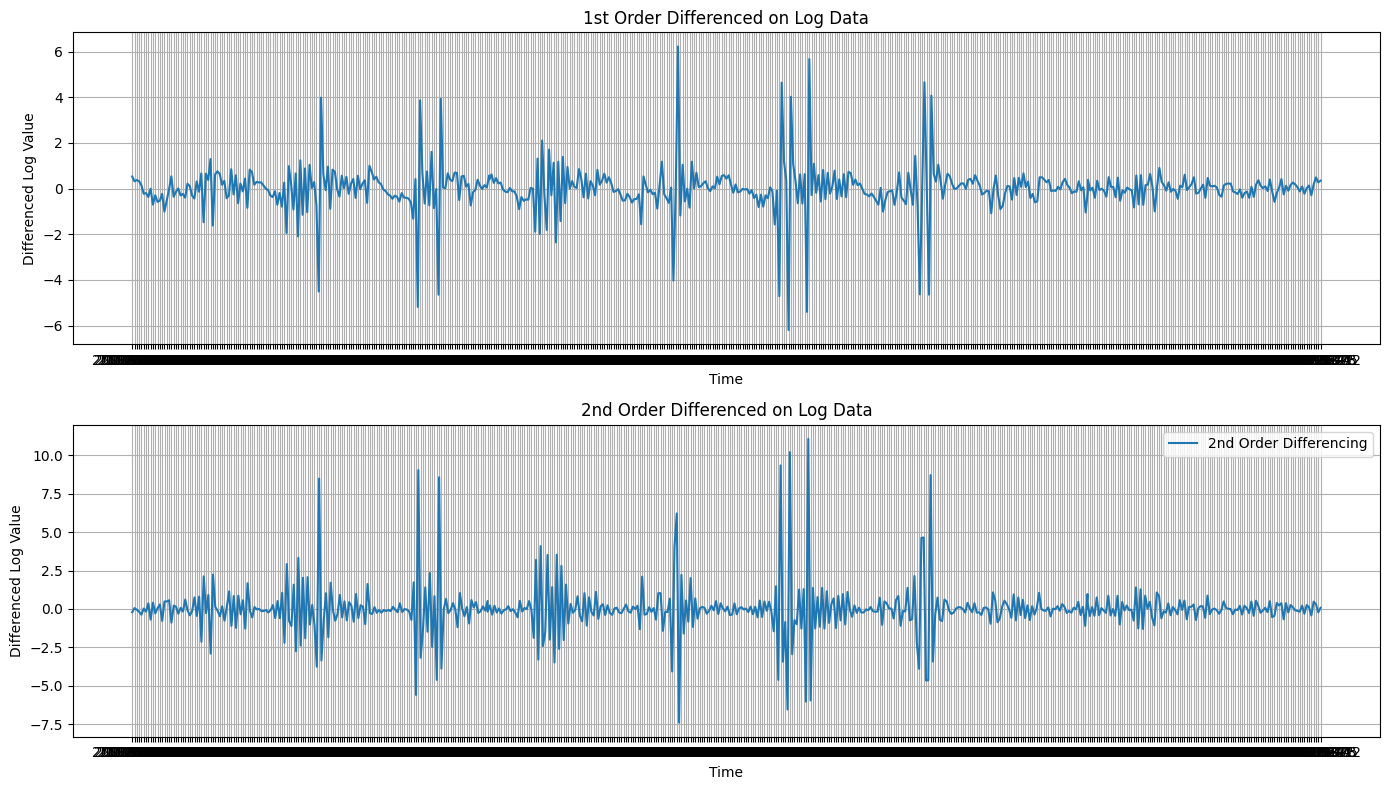

In [30]:
diff = pd.DataFrame(train["log"].diff())
diff = diff.dropna()

diff2 = pd.DataFrame(diff["log"].diff())
diff2 = diff2.dropna()

fig, axs = plt.subplots(2, 1, figsize=(14, 8))

# Plot for 1st Order Differencing
axs[0].plot(diff, label='1st Order Differencing')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Differenced Log Value')
axs[0].set_title('1st Order Differenced on Log Data')
axs[0].grid()  # Add grid to the first plot

# Plot for 2nd Order Differencing
axs[1].plot(diff2, label='2nd Order Differencing')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Differenced Log Value')
axs[1].set_title('2nd Order Differenced on Log Data')
axs[1].grid()

plt.tight_layout()
plt.legend()
plt.show()
# Even though the tests above tells us there is no need for differencing, we still do it but the pattern persists.


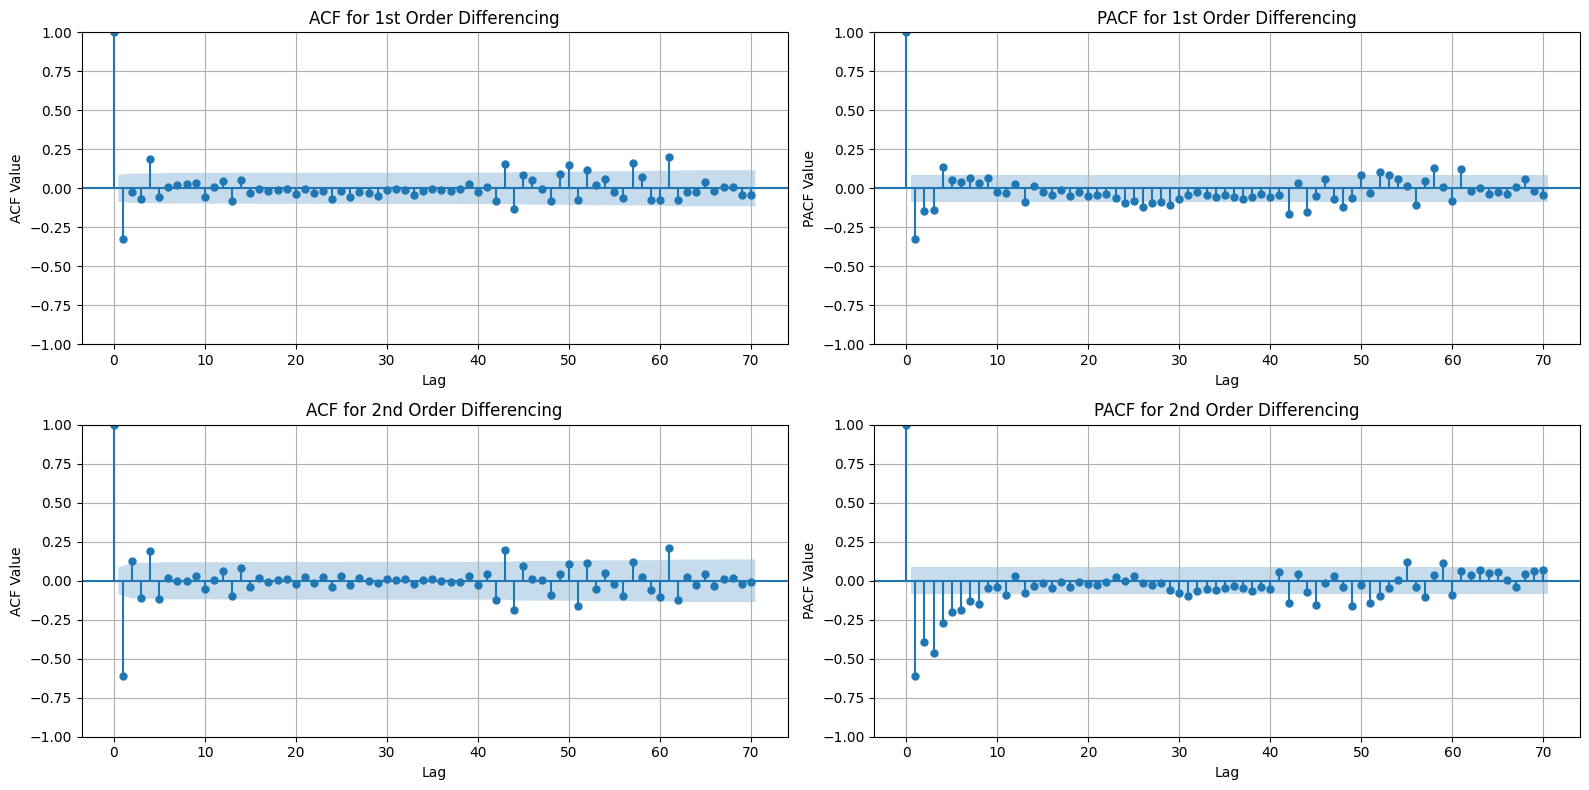

In [31]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8))

# Plot ACF for diff
plot_acf(diff, lags=70, ax=axs[0, 0])
axs[0, 0].set_title('ACF for 1st Order Differencing')
axs[0, 0].set_xlabel('Lag')
axs[0, 0].set_ylabel('ACF Value')
axs[0, 0].grid()

# Plot PACF for diff
plot_pacf(diff, lags=70, ax=axs[0, 1])
axs[0, 1].set_title('PACF for 1st Order Differencing')
axs[0, 1].set_xlabel('Lag')
axs[0, 1].set_ylabel('PACF Value')
axs[0, 1].grid()

# Plot ACF for diff2
plot_acf(diff2, lags=70, ax=axs[1, 0])
axs[1, 0].set_title('ACF for 2nd Order Differencing')
axs[1, 0].set_xlabel('Lag')
axs[1, 0].set_ylabel('ACF Value')
axs[1, 0].grid()

# Plot PACF for diff2
plot_pacf(diff2, lags=70, ax=axs[1, 1])
axs[1, 1].set_title('PACF for 2nd Order Differencing')
axs[1, 1].set_xlabel('Lag')
axs[1, 1].set_ylabel('PACF Value')
axs[1, 1].grid()

plt.tight_layout()
plt.show()
# Decaying ACF and PACF for 1st order differencing and 2nd order differencing
# possible another differencing method?

## seasonal differencing

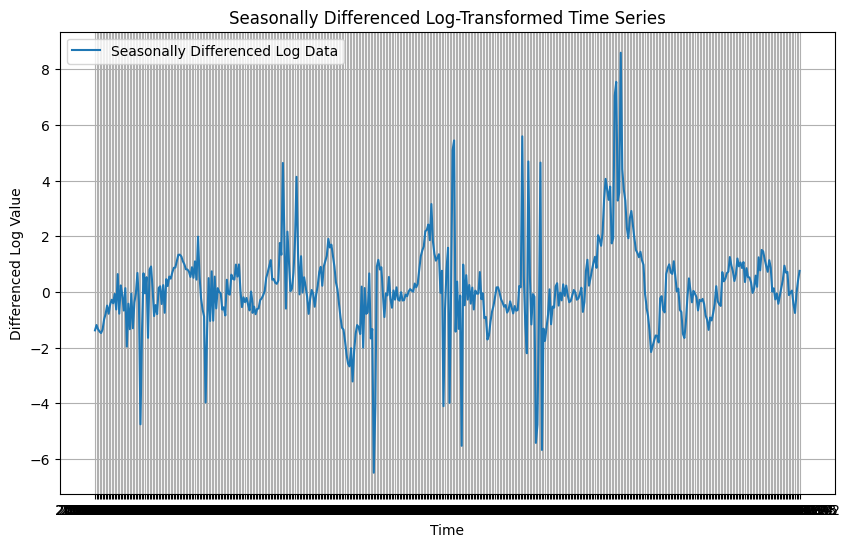

In [32]:
# Define the lag (seasonal period)
lag = 52  # For yearly seasonality (e.g., weekly data)

# Perform seasonal differencing on the log-transformed data
seasonal_differenced_data = train["log"].diff(lag)

# Drop NaN values (resulting from the diff operation)
seasonal_differenced_data = seasonal_differenced_data.dropna()

# Now, seasonal_differenced_data contains the seasonally differenced log-transformed data
plt.figure(figsize=(10, 6))
plt.plot(seasonal_differenced_data, label='Seasonally Differenced Log Data')
plt.title('Seasonally Differenced Log-Transformed Time Series')
plt.xlabel('Time')
plt.ylabel('Differenced Log Value')
plt.legend()
plt.grid()
plt.show()
# After seasonl differencing on log-transformation, it seems to be stationary.

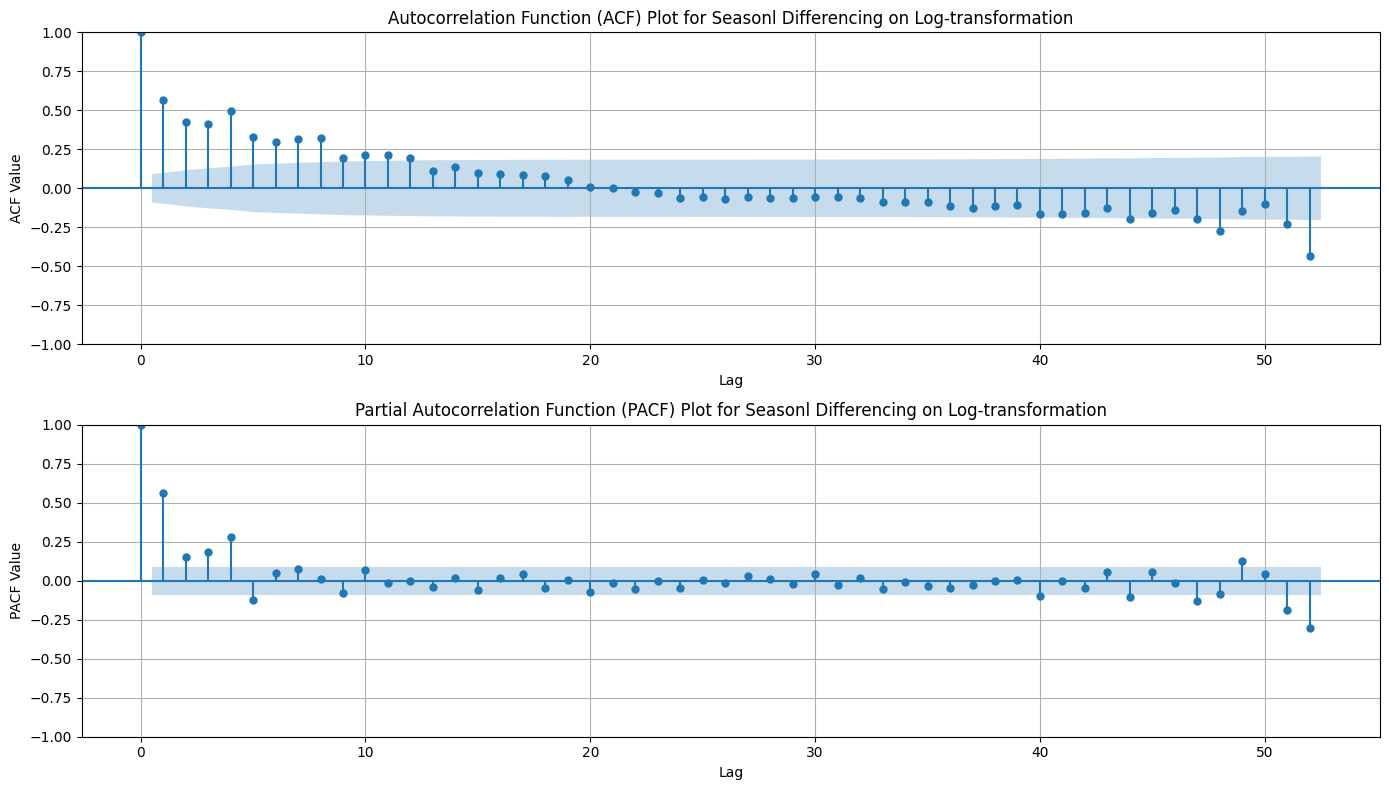

In [33]:
fig, axs = plt.subplots(2, 1, figsize=(14, 8))

# Plot the ACF
plot_acf(seasonal_differenced_data, lags=52, ax=axs[0])  # You can specify the number of lags to display
axs[0].set_title('Autocorrelation Function (ACF) Plot for Seasonl Differencing on Log-transformation')
axs[0].set_xlabel('Lag')
axs[0].set_ylabel('ACF Value')
axs[0].grid()

# Plot the PACF
plot_pacf(seasonal_differenced_data, lags=52, ax=axs[1])  # You can specify the number of lags to display
axs[1].set_title('Partial Autocorrelation Function (PACF) Plot for Seasonl Differencing on Log-transformation')
axs[1].set_xlabel('Lag')
axs[1].set_ylabel('PACF Value')
axs[1].grid()

plt.tight_layout()
plt.show()
# Decay ACF and PACF is a good sign for stationality
#From ACF and PACF we could induce that the optimum mivong average is 10 and the autoregressive order is 4.

# ARIMA

In [34]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import numpy as np
import warnings

In [45]:
warnings.filterwarnings("ignore")

# Finding the optimal ARIMA parameters using AIC (Auto ARIMA can also be used for more rigorous testing)
aic_values = {}
RMSE = {}
d = 0
for p in range(8):
    for q in range(13):
        try:
            model = ARIMA(train["log"], order=(p, d, q))
            model_arima = model.fit()
            aic_values[(p, d, q)] = model_arima.aic

            pred = model_arima.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=False)
            pred = np.exp(pred) - 1
            pred_data = pd.DataFrame({'pred': pred})
            pred_data.index = test.index
            RMSE[(p, d, q)] = mean_squared_error(test["original"], pred_data)

            print(f"ARIMA({p}, {d}, {q}) with AIC: {model_arima.aic}, RMSE is {mean_squared_error(test["original"], pred_data)}")

        except:
            continue

# Selecting the best (p, d, q) based on the lowest AIC value
best_pdq = min(aic_values, key=aic_values.get)
lowst_rmse = min(RMSE, key = RMSE.get)

print("lowest RMSE ARIMA is: ", lowst_rmse, RMSE[lowst_rmse])
print("lowest AIC ARIMA is: ", best_pdq, aic_values[best_pdq])

# Nonetheless, we still try with different parameters without differencing, knowing a lag of 3 from PACF and moving average of 6 from ACF.
# It is likely for ARIMA(4,0,11) to have the best performing parameters with the lowest AIC.
# ARIMA(2,0,11) is the best model according its lowest AIC value. 
# The reason why ARIMA(2,0,11) is the best might due to taking white noises for forecasting.


ARIMA(0, 0, 0) with AIC: 2196.2673642658865, RMSE is 22180525.506668374
ARIMA(0, 0, 1) with AIC: 1875.9672068201799, RMSE is 20702730.28463904
ARIMA(0, 0, 2) with AIC: 1696.0270245716792, RMSE is 19260787.16219758
ARIMA(0, 0, 3) with AIC: 1655.8984034018074, RMSE is 18572635.44470116
ARIMA(0, 0, 4) with AIC: 1571.4223275481659, RMSE is 16480830.067615524
ARIMA(0, 0, 5) with AIC: 1541.4774061182216, RMSE is 16046692.691095537
ARIMA(0, 0, 6) with AIC: 1517.0120572848627, RMSE is 15378419.102480402
ARIMA(0, 0, 7) with AIC: 1499.674562597124, RMSE is 14432942.681516262
ARIMA(0, 0, 8) with AIC: 1486.9582266436594, RMSE is 13968403.202069387
ARIMA(0, 0, 9) with AIC: 1463.8089398066631, RMSE is 13068086.079772936
ARIMA(0, 0, 10) with AIC: 1460.9524597685054, RMSE is 12797914.631572843
ARIMA(0, 0, 11) with AIC: 1454.7683488012544, RMSE is 12392150.0350439
ARIMA(0, 0, 12) with AIC: 1441.0532421722473, RMSE is 11941865.779146664
ARIMA(1, 0, 0) with AIC: 1491.8618810181133, RMSE is 11241507.19550

## Trial

                               SARIMAX Results                                
Dep. Variable:                    log   No. Observations:                  520
Model:                 ARIMA(5, 0, 6)   Log Likelihood                -688.091
Date:                Tue, 05 Dec 2023   AIC                           1402.182
Time:                        02:26:39   BIC                           1457.482
Sample:                             0   HQIC                          1423.845
                                - 520                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.3224      1.067      6.863      0.000       5.231       9.413
ar.L1          1.0934      0.048     22.623      0.000       0.999       1.188
ar.L2          1.6749      0.091     18.335      0.0

<function matplotlib.pyplot.show(close=None, block=None)>

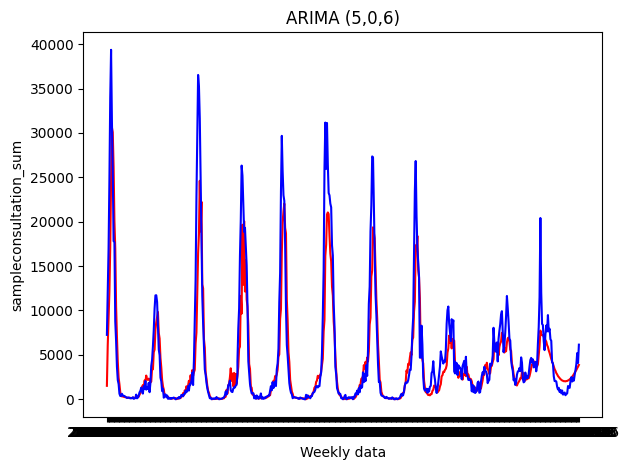

In [48]:
model = ARIMA(train["log"], order=(5, 0, 6))
model_arima = model.fit()
print(model_arima.summary())

pred = model_arima.predict(start=0, end=len(train) + len(test) - 1, dynamic=False)
pred = np.exp(pred) - 1
pred_data = pd.DataFrame({'pred': pred})
pred_data.index = flu_clean_imputed.index

plt.title("ARIMA (5,0,6)")
plt.ylabel("sampleconsultation_sum")
plt.xlabel("Weekly data")
plt.plot(pred_data, color = "red", label = "predicted")
plt.plot(flu_clean_imputed['original'], color = "blue", label = "actual")
plt.tight_layout()
plt.show

expanding cross validation will be used because the dataset is quite small with unexpected spikes

# SARIMA

In [ ]:
log_sarima = SARIMAX(train["log"], order=(0, 0, 0), seasonal_order=(4, 1, 10, 52))
log_sarima_model = log_sarima.fit(maxiter=20)

# Summary of the SARIMA model fitted on log-transformed data
log_sarima_model.summary()
pred_sarima = log_sarima_model.get_forecast(steps=len(test))
pred_sarima_mean = pred_sarima.predicted_mean